In [1]:
%matplotlib inline
#Reference from https://pytorch.org/

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
'''
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
'''
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(224),
        transforms.Resize([224, 224]),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(180),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize([224, 224]),
        #transforms.Resize(256),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_transforms = {
    'train': transforms.Compose([
        transforms.Resize([224, 224]),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(180),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize([224, 224]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


data_dir = '../AddMoreData061823/Class2/TTV'
l = []
l.append(datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train']))
l.append(datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train']))
l.append(datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train']))
l.append(datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train']))
#l.append(datasets.ImageFolder(os.path.join(data_dir, 'test'), data_transforms['test']))
image_datasetss = torch.utils.data.ConcatDataset(l)
image_datasets = {}
image_datasets['train'] = image_datasetss
image_datasets['test'] = datasets.ImageFolder(os.path.join(data_dir, 'test'), data_transforms['test'])
image_datasets['val'] = datasets.ImageFolder(os.path.join(data_dir, 'val'), data_transforms['test'])
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=5,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test', 'val']}
class_names = image_datasets['test'].classes
print(class_names)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(len( image_datasets['train']))
print(len( image_datasets['val']))
print(len( image_datasets['test']))

['0', '1', '2', '3', '4']
3020
92
98


Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



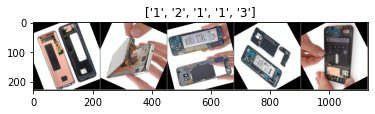

['0', '1', '2', '3', '4']


In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

print(class_names)

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs+1):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    #print(outputs)
                    #print(labels)
                    loss = criterion(outputs, labels)
    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            m = nn.Softmax(dim=1)
            proOutput = m(outputs)
            pros = proOutput.detach().cpu().numpy()
            #print(pros)
            #_, preds = torch.max(outputs, 1)
            #pro = torch.max(proOutput, dim=1)[0]
            #_, predsmin = torch.min(outputs, 1)
            #promin = torch.min(proOutput, dim=1)[0]

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                #ax.set_title('predicted: %s with %s probabilities' %(class_names[preds[j]], round(pro[j].item(),4)))
                print('Actual label: %s' %(class_names[labels[j].item()]))
                for jj in range(5):
                    print('predicted: %s with %s probabilities' %(class_names[jj], round(pros[j][jj],4)))
                #print('predicted: %s with %s probabilities' %(class_names[1], round(pros[j][1],4)))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
                
        model.train(mode=was_training)

#visualize_model(model_ft)

In [7]:
model_ft = models.vgg16(pretrained=True) #load googlenet.

#print(model_ft)

#num_ftrs = model_ft.fc.in_features

model_ft.classifier[-1] = nn.Linear(4096, 5)

#num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
#model_ft.fc = nn.Linear(num_ftrs, 5)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.01)

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [8]:
ep = 100
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=ep)

Epoch 1/100
----------
train Loss: 1.3257 Acc: 0.3911
val Loss: 1.1435 Acc: 0.5217

Epoch 2/100
----------
train Loss: 1.1332 Acc: 0.5116
val Loss: 1.1473 Acc: 0.5543

Epoch 3/100
----------
train Loss: 0.9660 Acc: 0.6129
val Loss: 1.0695 Acc: 0.5652

Epoch 4/100
----------
train Loss: 0.8292 Acc: 0.6808
val Loss: 0.9225 Acc: 0.6522

Epoch 5/100
----------
train Loss: 0.7018 Acc: 0.7374
val Loss: 0.9652 Acc: 0.6957

Epoch 6/100
----------
train Loss: 0.6307 Acc: 0.7642
val Loss: 0.8288 Acc: 0.7065

Epoch 7/100
----------
train Loss: 0.4355 Acc: 0.8427
val Loss: 1.1593 Acc: 0.5978

Epoch 8/100
----------
train Loss: 0.3200 Acc: 0.8841
val Loss: 0.9316 Acc: 0.6630

Epoch 9/100
----------
train Loss: 0.2072 Acc: 0.9331
val Loss: 0.9202 Acc: 0.6957

Epoch 10/100
----------
train Loss: 0.1780 Acc: 0.9351
val Loss: 0.9123 Acc: 0.6848

Epoch 11/100
----------
train Loss: 0.1470 Acc: 0.9497
val Loss: 0.9260 Acc: 0.6957

Epoch 12/100
----------
train Loss: 0.1461 Acc: 0.9550
val Loss: 0.9205 Ac

val Loss: 0.9329 Acc: 0.6848

Epoch 98/100
----------
train Loss: 0.1046 Acc: 0.9685
val Loss: 0.9329 Acc: 0.6848

Epoch 99/100
----------
train Loss: 0.1207 Acc: 0.9603
val Loss: 0.9329 Acc: 0.6848

Epoch 100/100
----------
train Loss: 0.1218 Acc: 0.9583
val Loss: 0.9329 Acc: 0.6848

Epoch 101/100
----------
train Loss: 0.1109 Acc: 0.9623
val Loss: 0.9329 Acc: 0.6848

Training complete in 94m 50s
Best val Acc: 0.706522


Actual label: 2
predicted: 0 with 0.0047 probabilities
predicted: 1 with 0.0265 probabilities
predicted: 2 with 0.7363 probabilities
predicted: 3 with 0.2033 probabilities
predicted: 4 with 0.0293 probabilities


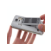

Actual label: 3
predicted: 0 with 0.0356 probabilities
predicted: 1 with 0.0387 probabilities
predicted: 2 with 0.3952 probabilities
predicted: 3 with 0.4503 probabilities
predicted: 4 with 0.0802 probabilities


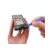

Actual label: 3
predicted: 0 with 0.0203 probabilities
predicted: 1 with 0.0365 probabilities
predicted: 2 with 0.2142 probabilities
predicted: 3 with 0.671 probabilities
predicted: 4 with 0.0579 probabilities


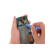

Actual label: 3
predicted: 0 with 1e-04 probabilities
predicted: 1 with 0.0006 probabilities
predicted: 2 with 0.0485 probabilities
predicted: 3 with 0.9458 probabilities
predicted: 4 with 0.0049 probabilities


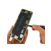

Actual label: 2
predicted: 0 with 0.0 probabilities
predicted: 1 with 0.0 probabilities
predicted: 2 with 0.9985 probabilities
predicted: 3 with 1e-04 probabilities
predicted: 4 with 0.0013 probabilities


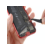

Actual label: 4
predicted: 0 with 0.0513 probabilities
predicted: 1 with 0.0688 probabilities
predicted: 2 with 0.0546 probabilities
predicted: 3 with 0.3619 probabilities
predicted: 4 with 0.4634 probabilities


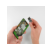

Actual label: 1
predicted: 0 with 0.0545 probabilities
predicted: 1 with 0.8048 probabilities
predicted: 2 with 0.1107 probabilities
predicted: 3 with 0.0251 probabilities
predicted: 4 with 0.005 probabilities


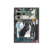

Actual label: 1
predicted: 0 with 0.0082 probabilities
predicted: 1 with 0.0204 probabilities
predicted: 2 with 0.5889 probabilities
predicted: 3 with 0.2689 probabilities
predicted: 4 with 0.1136 probabilities


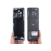

Actual label: 3
predicted: 0 with 0.0005 probabilities
predicted: 1 with 0.0011 probabilities
predicted: 2 with 0.0027 probabilities
predicted: 3 with 0.9949 probabilities
predicted: 4 with 0.0009 probabilities


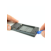

Actual label: 3
predicted: 0 with 0.0108 probabilities
predicted: 1 with 0.2139 probabilities
predicted: 2 with 0.6167 probabilities
predicted: 3 with 0.1489 probabilities
predicted: 4 with 0.0097 probabilities


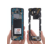

In [9]:
visualize_model(model_ft, 10)

In [10]:
correct = 0
total = 0
nb_classes = 5
confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for data in dataloaders['train']:
        images, labels = data[0].cuda(), data[1].cuda()
        outputs = model_ft(images)
        predicted = torch.round(outputs)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
        

print('Accuracy of the network on the %s train images: %d %%' % (total,
    100 * correct / total))

print(confusion_matrix)
b= torch.sum(confusion_matrix, dim=1)
print(confusion_matrix/torch.reshape(b, (-1, 1))) #Normalizing


Accuracy of the network on the 3020 train images: 83 %
tensor([[ 134.,   23.,   26.,   29.,    0.],
        [   4.,  363.,  142.,   35.,    0.],
        [   0.,    0., 1013.,   40.,   15.],
        [   0.,    4.,  127.,  916.,    5.],
        [   0.,    3.,   27.,   14.,  100.]])
tensor([[0.6321, 0.1085, 0.1226, 0.1368, 0.0000],
        [0.0074, 0.6673, 0.2610, 0.0643, 0.0000],
        [0.0000, 0.0000, 0.9485, 0.0375, 0.0140],
        [0.0000, 0.0038, 0.1207, 0.8707, 0.0048],
        [0.0000, 0.0208, 0.1875, 0.0972, 0.6944]])


In [11]:
correct = 0
total = 0
nb_classes = 5
confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for data in dataloaders['val']:
        images, labels = data[0].cuda(), data[1].cuda()
        outputs = model_ft(images)
        predicted = torch.round(outputs)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
        

print('Accuracy of the network on the %s val images: %d %%' % (total,
    100 * correct / total))

print(confusion_matrix)
b= torch.sum(confusion_matrix, dim=1)
print(confusion_matrix/torch.reshape(b, (-1, 1))) #Normalizing


Accuracy of the network on the 92 val images: 70 %
tensor([[ 2.,  2.,  2.,  0.,  0.],
        [ 1.,  5.,  6.,  5.,  0.],
        [ 0.,  1., 28.,  4.,  0.],
        [ 0.,  1.,  2., 27.,  2.],
        [ 0.,  0.,  1.,  0.,  3.]])
tensor([[0.3333, 0.3333, 0.3333, 0.0000, 0.0000],
        [0.0588, 0.2941, 0.3529, 0.2941, 0.0000],
        [0.0000, 0.0303, 0.8485, 0.1212, 0.0000],
        [0.0000, 0.0312, 0.0625, 0.8438, 0.0625],
        [0.0000, 0.0000, 0.2500, 0.0000, 0.7500]])


In [12]:
correct = 0
total = 0
nb_classes = 5
confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for data in dataloaders['test']:
        images, labels = data[0].cuda(), data[1].cuda()
        outputs = model_ft(images)
        predicted = torch.round(outputs)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
        

print('Accuracy of the network on the %s test images: %d %%' % (total,
    100 * correct / total))

print(confusion_matrix)
b= torch.sum(confusion_matrix, dim=1)
print(confusion_matrix/torch.reshape(b, (-1, 1))) #Normalizing


Accuracy of the network on the 98 test images: 63 %
tensor([[ 2.,  0.,  2.,  4.,  0.],
        [ 0.,  8.,  9.,  0.,  0.],
        [ 0.,  0., 27.,  7.,  0.],
        [ 0.,  2.,  9., 23.,  0.],
        [ 1.,  0.,  1.,  1.,  2.]])
tensor([[0.2500, 0.0000, 0.2500, 0.5000, 0.0000],
        [0.0000, 0.4706, 0.5294, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.7941, 0.2059, 0.0000],
        [0.0000, 0.0588, 0.2647, 0.6765, 0.0000],
        [0.2000, 0.0000, 0.2000, 0.2000, 0.4000]])


In [13]:
if not os.path.exists('trained models'):
   os.makedirs('trained models')
PATH = './trained models/VGG-TTVClass2-BestEP%s.pth' %(ep)
torch.save(model_ft.state_dict(), PATH)